# Text Generation using Tensorflow, Keras and LSTM

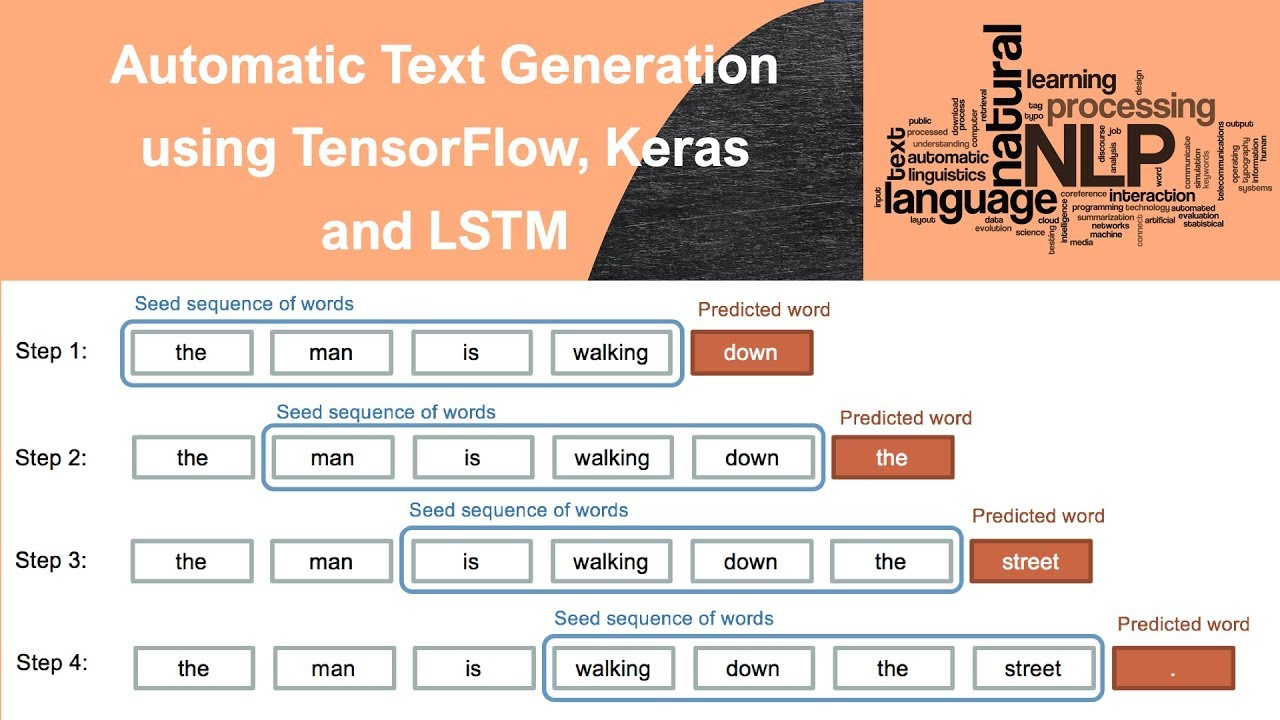

In [1]:
import tensorflow as tf
import string
import requests
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences

>>Don't forget to change the runtime type to TPU in your Colab Notebook!

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Device: 
Number of replicas: 8


In [3]:
response = requests.get('https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt')
response.text

Output hidden; open in https://colab.research.google.com to view.

In [4]:
data = response.text.split('\n')
data[0]

'This is the 100th Etext file presented by Project Gutenberg, and'

In [5]:
data = data[253:]
data[0]

'  From fairest creatures we desire increase,'

In [6]:
len(data)

124204

In [7]:
data = " ".join(data)
data

Output hidden; open in https://colab.research.google.com to view.

In [8]:
def clean_text(doc):
  tokens = doc.split()
  table = str.maketrans('', '', string.punctuation)
  tokens = [w.translate(table) for w in tokens]
  tokens = [word for word in tokens if word.isalpha()]
  tokens = [word.lower() for word in tokens]
  return tokens

In [9]:
tokens = clean_text(data)
print(tokens[:50])

['from', 'fairest', 'creatures', 'we', 'desire', 'increase', 'that', 'thereby', 'beautys', 'rose', 'might', 'never', 'die', 'but', 'as', 'the', 'riper', 'should', 'by', 'time', 'decease', 'his', 'tender', 'heir', 'might', 'bear', 'his', 'memory', 'but', 'thou', 'contracted', 'to', 'thine', 'own', 'bright', 'eyes', 'feedst', 'thy', 'lights', 'flame', 'with', 'selfsubstantial', 'fuel', 'making', 'a', 'famine', 'where', 'abundance', 'lies', 'thy']


In [10]:
len(tokens)

898199

In [11]:
len(set(tokens))

27956

In [12]:
length = 50 + 1
lines = []
for i in range(length, len(tokens)):
  seq = tokens[i-length:i]
  line = ' '.join(seq)
  lines.append(line)
  if i > 200000:
    break
print(len(lines))

199951


In [13]:
lines[0]

'from fairest creatures we desire increase that thereby beautys rose might never die but as the riper should by time decease his tender heir might bear his memory but thou contracted to thine own bright eyes feedst thy lights flame with selfsubstantial fuel making a famine where abundance lies thy self'

In [14]:
tokens[0:5]

['from', 'fairest', 'creatures', 'we', 'desire']

In [15]:
lines[1]

'fairest creatures we desire increase that thereby beautys rose might never die but as the riper should by time decease his tender heir might bear his memory but thou contracted to thine own bright eyes feedst thy lights flame with selfsubstantial fuel making a famine where abundance lies thy self thy'

## Build LSTM Model and Prepare `X` and `y`

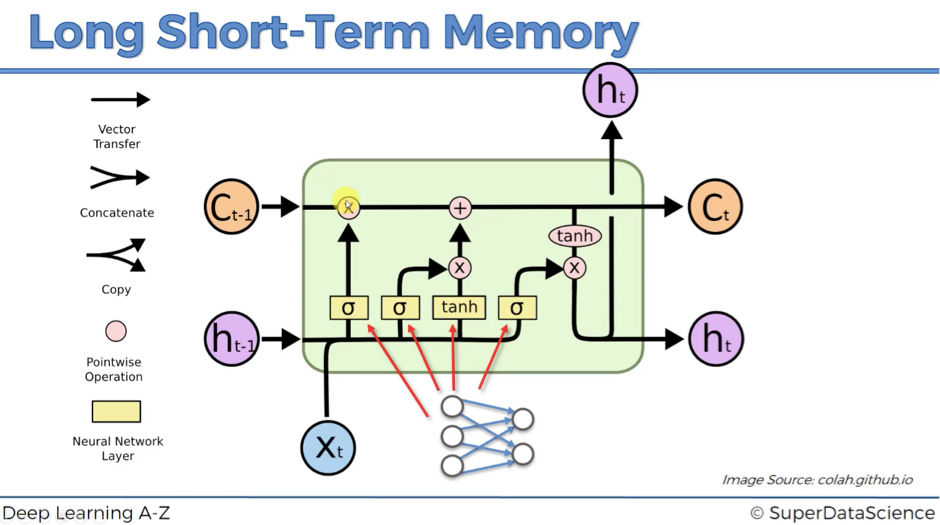



In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)

In [17]:
tokenizer.word_index

{'the': 1,
 'and': 2,
 'i': 3,
 'to': 4,
 'of': 5,
 'you': 6,
 'a': 7,
 'my': 8,
 'that': 9,
 'in': 10,
 'is': 11,
 'not': 12,
 'it': 13,
 'for': 14,
 'me': 15,
 'with': 16,
 'he': 17,
 'his': 18,
 'your': 19,
 'but': 20,
 'be': 21,
 'this': 22,
 'have': 23,
 'as': 24,
 'him': 25,
 'so': 26,
 'thou': 27,
 'will': 28,
 'what': 29,
 'by': 30,
 'thy': 31,
 'no': 32,
 'are': 33,
 'all': 34,
 'her': 35,
 'do': 36,
 'we': 37,
 'if': 38,
 'our': 39,
 'or': 40,
 'shall': 41,
 'thee': 42,
 'which': 43,
 'on': 44,
 'lord': 45,
 'o': 46,
 'from': 47,
 'good': 48,
 'more': 49,
 'sir': 50,
 'was': 51,
 'they': 52,
 'well': 53,
 'at': 54,
 'would': 55,
 'when': 56,
 'now': 57,
 'come': 58,
 'love': 59,
 'th': 60,
 'than': 61,
 'am': 62,
 'then': 63,
 'she': 64,
 'their': 65,
 'them': 66,
 'how': 67,
 'enter': 68,
 'let': 69,
 'did': 70,
 'ill': 71,
 'hath': 72,
 'one': 73,
 'us': 74,
 'know': 75,
 'first': 76,
 'make': 77,
 'had': 78,
 'like': 79,
 'here': 80,
 'upon': 81,
 'there': 82,
 'man': 83,


In [18]:
len(tokenizer.word_index)

13008

In [19]:
sequences = np.array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]
vocab_size = len(tokenizer.word_index) + 1
y = to_categorical(y, num_classes=vocab_size)
seq_length = X.shape[1]

In [20]:
X[0]

array([   47,  1408,  1264,    37,   451,  1406,     9,  2766,  1158,
        1213,   171,   132,   269,    20,    24,     1,  4782,    87,
          30,    98,  4781,    18,   715,  1263,   171,   211,    18,
         829,    20,    27,  3807,     4,   214,   121,  1212,   153,
       13004,    31,  2765,  1847,    16, 13003, 13002,   754,     7,
        3806,    99,  2430,   466,    31])

In [21]:
y[0]

array([0., 0., 0., ..., 0., 0., 0.])

LSTM Model

In [24]:
with strategy.scope():
    model = Sequential()
    model.add(Embedding(vocab_size, 50))
    model.add(LSTM(100, return_sequences=True))
    model.add(LSTM(100))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(vocab_size, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
        )

In [25]:
model.fit(X, y, batch_size=256, epochs=100)

Epoch 1/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 38ms/step - accuracy: nan - loss: nan
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - accuracy: nan - loss: nan
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: nan - loss: nan
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: nan - loss: nan
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - accuracy: nan - loss: nan
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - accuracy: nan - loss: nan
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - accuracy: nan - loss: nan
Epoch 8/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - accuracy: nan - loss: nan
Epoch 9/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - accuracy: nan - loss: nan
Epoch 10/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - accuracy: nan - loss: nan
Epoch 11/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - accuracy: nan - loss: nan
Epoch 12/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - accuracy: nan - loss: nan
E

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (32, 50, 50)                │         650,450 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (32, 50, 100)               │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (32, 100)                   │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 100)                   │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 13009)                 │       1,313,909 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,345,779 (24.21 MB)

 Trainable params: 2,115,259 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,230,520 (16.14 MB)

In [27]:
lines[12343]

'home of love if i have ranged like him that travels i return again just to the time not with the time exchanged so that my self bring water for my stain never believe though in my nature reigned all frailties that besiege all kinds of blood that it could so'

In [49]:
def generate_text_seq(model, tokenizer, text_seq_length, seed_text, n_words):
    text = []
    for _ in range(n_words):
        encoded = tokenizer.texts_to_sequences([seed_text])[0]
        encoded = pad_sequences([encoded], maxlen=text_seq_length, truncating='pre')
        y_predict = np.argmax(model.predict(encoded), axis=-1)
        predicted_word = ''
        for word, index in tokenizer.word_index.items():
            if index == y_predict[0]:
                predicted_word = word
                break
        seed_text = seed_text + ' ' + predicted_word
        text.append(predicted_word)
    return ' '.join(text)

#seed_text = "the quick brown"
n_words_to_generate = 10

In [50]:
generated_text = generate_text_seq(model, tokenizer, seq_length, seed_text, n_words_to_generate)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step


In [51]:
print(generated_text)

fights belarius i have seen the countercheck sap of boys


In [52]:
seed_text

'the quick brown'